# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import pandas as pd
import pygraphviz as pgv
from pygraphviz import AGraph
import random

In [3]:
# Import the tables of the data set as dataframes.

DATA_DIR = './data' # You many change the directory

# You can use the nrows=X argument in pd.read_csv to truncate your data
users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)

## Task 0: Research Question

**Research question:**
*Your chosen research question goes here*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [4]:
# In subtasks dataset exist more event_id than in events dataset
print(len(events))
print(len(subtasks))
subtasks = subtasks[subtasks.event_id < len(events)]

# set the game names in subtasks dataset
subtasks = subtasks.copy()
subtasks['game_name'] = events.iloc[subtasks['event_id']]['game_name'].values

34094
55047


In [5]:
# Your code for data processing goes here
#G = nx.MultiGraph(nx.nx_agraph.read_dot('04_calcularis_skill_map_dot_file.dot'))
#G = pgv.AGraph('04_calcularis_skill_map_dot_file.dot', directed=False)

*Your discussion about your processing decisions goes here*

In [14]:
#Create graph as long as we dont have one
DG = nx.path_graph(5, create_using=nx.DiGraph)

#The data to check how the calculate_mastery_level function works
user_subtasks = subtasks.loc[subtasks['user_id'] == 1]
user_subtasks = user_subtasks.copy()
user_subtasks['subtask_finished_timestamp'] = pd.to_datetime(user_subtasks['subtask_finished_timestamp'])

user_subtasks = user_subtasks.dropna(subset=['subtask_finished_timestamp'])

start_date = user_subtasks['subtask_finished_timestamp'].min()

# Add the week number
user_subtasks['week_number'] = (((user_subtasks.subtask_finished_timestamp.view(np.int64) - pd.to_datetime([start_date]).view(np.int64)) / (1e9 * 60 * 60 * 24) - user_subtasks.subtask_finished_timestamp.dt.day_of_week + 7) // 7 + 1).astype(np.int64)

In [15]:
def calculate_mastery_level(G, user_subtasks, week, game):
    #Find the node id of the specified game
    node_id = 2 

    #Find the games of which the correctness should be calculated
    #games_graph = sorted(nx.ancestors(DG, 2) | {2})
    #games = ['Subitizing', 'Conversion', 'Landing']

    games = [game]
    
    answers = []
    user_subtasks = user_subtasks[user_subtasks['week_number'] < week]
    for idx, subtask in user_subtasks.iterrows():
        answers.append(subtask['game_name'] in games and subtask['correct'])

    if not answers:
        return 0
    return sum(answers) / len(answers)

calculate_mastery_level(DG, user_subtasks, 10, 'Subitizing')

0.2222222222222222

In [16]:
#create multindex
def create_dataframe_multi_index(G):
    multi_index = [[], [], []]
    df = pd.DataFrame(columns = ['mastery_level'], index = multi_index)
    df.index = df.index.set_names(['user_id', 'game_name', 'week'])

    for user_id, user in users.iterrows():
        #Get weeks
        user_subtasks = subtasks.loc[subtasks['user_id'] == user_id]
        user_subtasks = user_subtasks.copy()
        user_subtasks['subtask_finished_timestamp'] = pd.to_datetime(user_subtasks['subtask_finished_timestamp'])
        #user_subtasks.loc['subtask_finished_timestamp'] = user_subtasks.loc['subtask_finished_timestamp'].astype('datetime64[ns]')
        start_date = user_subtasks['subtask_finished_timestamp'].min()

        user_subtasks = user_subtasks.dropna(subset=['subtask_finished_timestamp'])
        # Add the week number
        user_subtasks['week_number'] = (((user_subtasks.subtask_finished_timestamp.view(np.int64) - pd.to_datetime([start_date]).view(np.int64)) / (1e9 * 60 * 60 * 24) - user_subtasks.subtask_finished_timestamp.dt.day_of_week + 7) // 7 + 1).astype(np.int64)
        
        #Get unique games names
        game_names = events.loc[subtasks['event_id']]['game_name'].unique()

        #Create an part of index
        unique_weeks = user_subtasks['week_number'].unique()
        len_weeks = len(unique_weeks)
        len_game_names = len(game_names)

        user_ids = [user_id for i in range(len_weeks * len_game_names)]

        weeks = user_subtasks['week_number'].unique()
        weeks = np.concatenate([weeks]* (len_game_names))

        user_unique_games = [game for game in game_names for week in range(len_weeks)]

        tuples = list(zip(user_ids, user_unique_games, weeks))

        index = pd.MultiIndex.from_tuples(tuples, names=['user_id', 'game_name', 'week'])

        df1 = pd.DataFrame(columns = ['mastery_level'], index = index)

        #mastery_level = np.array([1 for i in range(len_weeks * len_game_names)])
        mastery_level = []
        
        for game in game_names:
            for week in unique_weeks:
                #Calculate the skill id in the certain game after a certain number of weeks
                lv = calculate_mastery_level(G, user_subtasks, week, game)
                mastery_level.append(lv)
                
        mastery_level = pd.DataFrame(mastery_level, columns = ['mastery_level'])
        mastery_level.index = index
        df1['mastery_level'] = mastery_level
        df = pd.concat([df, df1], axis=0)
    return df

df = create_dataframe_multi_index(DG)

In [20]:
df.loc[[45]]
#df.loc[(457, 'Subitizing'), :]
random_user_ids = random.sample(range(len(users)), 10)
#sers.iloc[random_user_ids]

KeyError: (589, 'Subitizing')

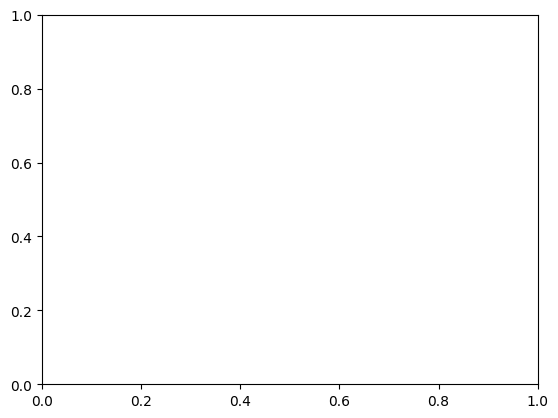

In [21]:
#Create visualization
def show_mastery_lvl(df, users, game):
    fig, ax = plt.subplots()
    for user in users:
        temp_df = df.loc[(user + 1, 'Subitizing'), :]
        temp_df.plot(y='mastery_level', kind='line', title=f'Mastery of {game} Over Time', ax=ax)
        plt.xlabel('weeks')
        plt.ylabel('mastery_level')
    plt.show()

show_mastery_lvl(df, random_user_ids, 'Subitizing')

## Task 2: Model Building

Train a model for your research question. 

In [ ]:
# Your code for training a model goes here

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [ ]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*